In [1]:
import pandas as pd

# C-MLP configuration:
# buffer size = 50 (history length = 40)
# forecast length = 10
# hidden layer size = 100
# epochs per sample = 10

results = pd.read_csv('results_Ivol_Acc_Load_data3_w3_w2_50per_STD_downBy256.lvm.csv')\
            [['Time', 'Observed', 'Predicted']].rename(columns={'Predicted': 'C-MLP Predicted'})

results

,Time,Observed,C-MLP Predicted
0,0.000000,0.024686,NaN
1,0.005000,-0.054070,NaN
2,0.010000,-0.009903,NaN
3,0.015000,0.055296,NaN
4,0.020000,-0.004513,NaN
...,...,...,...
3946,19.729988,NaN,-0.001072
3947,19.734988,NaN,-0.067375
3948,19.739988,NaN,0.113477
3949,19.744988,NaN,-0.089556


In [2]:
import json
import numpy as np

# W-MLP configuration:
# sample window = 50
# training window = 100
# hidden layer size = 10
# epochs = 200

raw = json.loads(open('result-10n-s50-t100-e200.json', 'r').read())

results = results.merge(
    results[['Time']].join(
        pd.DataFrame({'W-MLP Predicted': np.array(raw['y_data'])}, index=np.array(raw['x_data'])),
        how='outer'),
    on='Time',
    how='outer')

results

,Time,Observed,C-MLP Predicted,W-MLP Predicted
0,0.000000,0.024686,NaN,NaN
1,0.005000,-0.054070,NaN,NaN
2,0.010000,-0.009903,NaN,NaN
3,0.015000,0.055296,NaN,NaN
4,0.020000,-0.004513,NaN,NaN
...,...,...,...,...
3946,19.729988,NaN,-0.001072,NaN
3947,19.734988,NaN,-0.067375,NaN
3948,19.739988,NaN,0.113477,NaN
3949,19.744988,NaN,-0.089556,NaN


In [3]:
from matplotlib.lines import Line2D

max_time = results[['Time', 'Observed']].dropna().iloc[-1]['Time']
sample_rate = max_time / results[['Time', 'Observed']].dropna().shape[0]

rw_sizes = [1, int(1e-3 / sample_rate), int(10e-3 / sample_rate), int(100e-3 / sample_rate)]
rw_labels = ['per-sample', '1ms window', '10ms window', '100ms window']
plt_colors = ['lightsteelblue', 'dodgerblue', 'blue', 'purple']

valid_windows = []
rmse_legend = {'Error Threshold = 0.005 mv': Line2D([0], [0], color='red', linewidth=3, linestyle='--')}
mae_legend = rmse_legend.copy()

for i, s in enumerate(rw_sizes):
    if i == 0 or s > 1:
        color = plt_colors.pop(0)
        valid_windows.append((s, rw_labels[i], color))
        rmse_legend[f'RMSE {rw_labels[i]}'] = Line2D([0], [0], color=color, linewidth=3)
        mae_legend[f'MAE {rw_labels[i]}'] = Line2D([0], [0], color=color, linewidth=3)

valid_windows, rmse_legend, mae_legend

([(1, 'per-sample', 'lightsteelblue'),
  (2, '10ms window', 'dodgerblue'),
  (20, '100ms window', 'blue')],
 {'Error Threshold = 0.005 mv': <matplotlib.lines.Line2D at 0x7f68ed96afd0>,
  'RMSE per-sample': <matplotlib.lines.Line2D at 0x7f68ed96af70>,
  'RMSE 10ms window': <matplotlib.lines.Line2D at 0x7f68ed43f9a0>,
  'RMSE 100ms window': <matplotlib.lines.Line2D at 0x7f68ed43fee0>},
 {'Error Threshold = 0.005 mv': <matplotlib.lines.Line2D at 0x7f68ed96afd0>,
  'MAE per-sample': <matplotlib.lines.Line2D at 0x7f68ed4d87c0>,
  'MAE 10ms window': <matplotlib.lines.Line2D at 0x7f68ed43f8e0>,
  'MAE 100ms window': <matplotlib.lines.Line2D at 0x7f68ed3d0070>})

In [4]:
import sys; sys.path.append('..')
from utils.metrics import MetricsAdapter

cmlp_metrics = MetricsAdapter(
    results[['Time', 'Observed', 'C-MLP Predicted']].rename(columns={'C-MLP Predicted': 'Predicted'}))
wmlp_metrics = MetricsAdapter(
    results[['Time', 'Observed', 'W-MLP Predicted']].rename(columns={'W-MLP Predicted': 'Predicted'}))

for size, label, _ in valid_windows:
    if size == 1 or label != 'per-sample':
        cmlp_rmse_rolling = cmlp_metrics.rolling_rmse(size, f'C-MLP RMSE {label}')
        cmlp_mae_rolling = cmlp_metrics.rolling_mae(size, f'C-MLP MAE {label}')
        wmlp_rmse_rolling = wmlp_metrics.rolling_rmse(size, f'W-MLP RMSE {label}')
        wmlp_mae_rolling = wmlp_metrics.rolling_mae(size, f'W-MLP MAE {label}')
        
        results = results.merge(cmlp_rmse_rolling, on='Time', how='outer')
        results = results.merge(cmlp_mae_rolling, on='Time', how='outer')
        results = results.merge(wmlp_rmse_rolling, on='Time', how='outer')
        results = results.merge(wmlp_mae_rolling, on='Time', how='outer')

results

,Time,Observed,C-MLP Predicted,W-MLP Predicted,C-MLP RMSE per-sample,C-MLP MAE per-sample,W-MLP RMSE per-sample,W-MLP MAE per-sample,C-MLP RMSE 10ms window,C-MLP MAE 10ms window,W-MLP RMSE 10ms window,W-MLP MAE 10ms window,C-MLP RMSE 100ms window,C-MLP MAE 100ms window,W-MLP RMSE 100ms window,W-MLP MAE 100ms window
0,0.000000,0.024686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005000,-0.054070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.010000,-0.009903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.015000,0.055296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020000,-0.004513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,19.729988,NaN,-0.001072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3947,19.734988,NaN,-0.067375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948,19.739988,NaN,0.113477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,19.744988,NaN,-0.089556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


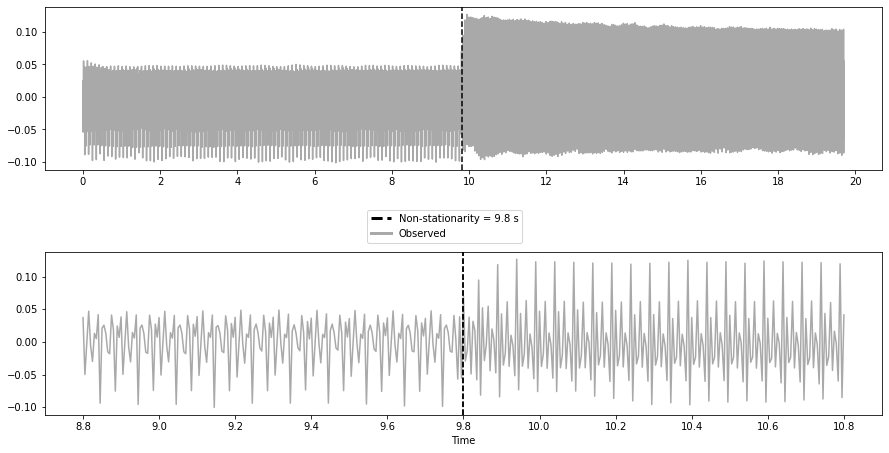

In [5]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

NON_STAT = 9.8

def query_time(lower, upper):
    return results.query(f'{lower} <= Time <= {upper}')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 7.5))

fig.legend(
    [Line2D([0], [0], color='black', linewidth=3, ls='--'),
     Line2D([0], [0], color='darkgray', linewidth=3)],
    [f'Non-stationarity = {NON_STAT} s',
     'Observed'],
    loc='center')

results.plot(y='Observed', x='Time', color='darkgray', ax=axs[0])
axs[0]
axs[0].set_xlabel('')
axs[0].xaxis.set_major_locator(MultipleLocator(base=2.0))

query_time(8.8, 10.8).plot(y='Observed', x='Time', color='darkgray', ax=axs[1])
axs[1].axvline(x=NON_STAT, color='black', ls='--')
axs[1].xaxis.set_major_locator(MultipleLocator(base=0.2))

for ax in axs:
    ax.axvline(x=NON_STAT, color='black', ls='--')
    ax.get_legend().remove()

plt.subplots_adjust(hspace=0.5)

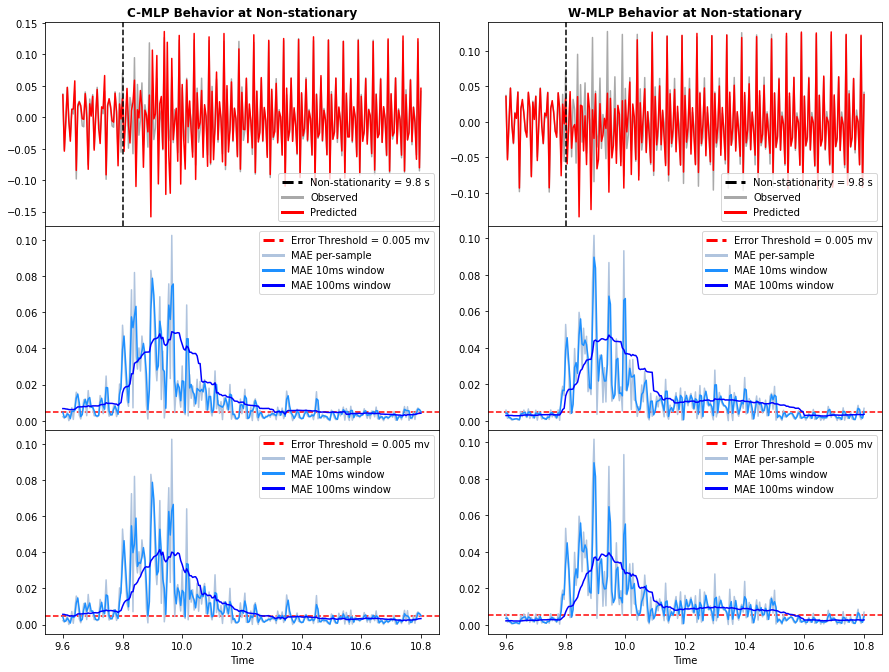

In [6]:
ERR_THRES = 0.005
lo, hi = 9.6, 10.8

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 11.25))

for m, ax in zip(['C-MLP Predicted', 'W-MLP Predicted'], axs[0, :]):
    ax.set_title(f'{m.split()[0]} Behavior at Non-stationary', fontweight='bold')
    query_time(lo, hi).plot(y='Observed', x='Time', color='darkgray', ax=ax)
    query_time(lo, hi).plot(y=m, x='Time', color='red', ax=ax)
    ax.axvline(x=NON_STAT, color='black', ls='--')
    ax.legend(
        [Line2D([0], [0], color='black', linewidth=3, ls='--'),
         Line2D([0], [0], color='darkgray', linewidth=3),
         Line2D([0], [0], color='red', linewidth=3)],
        [f'Non-stationarity = {NON_STAT} s',
         'Observed',
         'Predicted'],
        loc='lower right')

for m_err, ax in zip(['C-MLP RMSE', 'C-MLP MAE', 'W-MLP RMSE', 'W-MLP MAE'], axs[1:, :].T.flat):
    ax.axhline(y=ERR_THRES, color='red', ls='--')
    ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
    for _, label, color in valid_windows:
        query_time(lo, hi).plot(y=f'{m_err} {label}', x='Time', color=color, ax=ax)
    
    if m.split()[1] == 'RMSE':
        ax.legend(rmse_legend.values(), rmse_legend.keys())
    else:
        ax.legend(mae_legend.values(), mae_legend.keys())
    
plt.subplots_adjust(wspace=0.125, hspace=0)

In [7]:
def conv_times(model):
    rmse_peak = results.query(
        f'`{model} RMSE 100ms window` == {query_time(lo, hi)[f"{model} RMSE 100ms window"].max()}'
    )['Time'].item()
    
    rmse_thres_cross = query_time(rmse_peak, hi).query(
        f'`{model} RMSE 100ms window` <= {ERR_THRES}').head(1)['Time'].item()
    
    mae_peak = results.query(
        f'`{model} MAE 100ms window` == {query_time(lo, hi)[f"{model} MAE 100ms window"].max()}'
    )['Time'].item()
    
    mae_thres_cross = query_time(mae_peak, hi).query(
        f'`{model} MAE 100ms window` <= {ERR_THRES}').head(1)['Time'].item()
    
    return (rmse_thres_cross - rmse_peak), (mae_thres_cross - mae_peak)

cmlp_rmse_conv_time, cmlp_mae_conv_time = conv_times('C-MLP')
wmlp_rmse_conv_time, wmlp_mae_conv_time = conv_times('W-MLP')

cmlp_rmse_conv_time, cmlp_mae_conv_time, wmlp_rmse_conv_time, wmlp_mae_conv_time

(0.34500000000000064, 0.3349999999999991, 0.6549999999999994, 0.625)

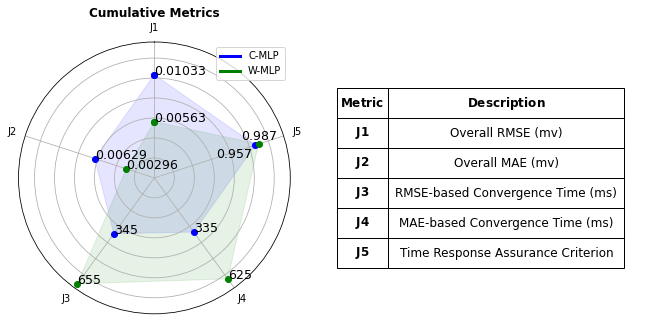

In [8]:
labels = np.array([
    'J1',  # overall RMSE
    'J2',  # overall MAE
    'J3',  # RMSE convergence time (ms)
    'J4',  # MAE convergence time (ms)
    'J5',  # TRAC
])

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

cmlp_values = np.array([
    cmlp_metrics.overall_rmse(),
    cmlp_metrics.overall_mae(),
    cmlp_rmse_conv_time / 50,
    cmlp_mae_conv_time / 50,
    cmlp_metrics.trac() / 90
])

wmlp_values = np.array([
    wmlp_metrics.overall_rmse(),
    wmlp_metrics.overall_mae(),
    wmlp_rmse_conv_time / 50,
    wmlp_mae_conv_time / 50,
    wmlp_metrics.trac() / 90
])

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, polar=True)

angles = np.append(angles, angles[0])
cmlp_values = np.append(cmlp_values, cmlp_values[0])
wmlp_values = np.append(wmlp_values, wmlp_values[0])

ax.plot(angles, cmlp_values, 'o', color='blue')
ax.fill(angles, cmlp_values, alpha=0.1, color='blue')
ax.plot(angles, wmlp_values, 'o', color='green')
ax.fill(angles, wmlp_values, alpha=0.1, color='green')

ax.set_title('Cumulative Metrics', fontweight='bold')
ax.set_thetagrids((angles[:-1] * 180) / np.pi, labels)
ax.set_theta_offset(np.pi / 2)
ax.set_yticklabels([])
ax.legend(
    [Line2D([0], [0], color='blue', linewidth=3), Line2D([0], [0], color='green', linewidth=3)],
    ['C-MLP', 'W-MLP'],
    loc='upper right')

size = 12.5

ax.annotate(round(cmlp_metrics.overall_rmse(), 5), (angles[0], cmlp_values[0]), fontsize=size)
ax.annotate(round(wmlp_metrics.overall_rmse(), 5), (angles[0], wmlp_values[0]), fontsize=size)

ax.annotate(round(cmlp_metrics.overall_mae(), 5), (angles[1], cmlp_values[1]), fontsize=size)
ax.annotate(round(wmlp_metrics.overall_mae(), 5), (angles[1], wmlp_values[1]), fontsize=size)

ax.annotate(round(cmlp_rmse_conv_time * 1e3), (angles[2], cmlp_values[2]), fontsize=size)
ax.annotate(round(wmlp_rmse_conv_time * 1e3), (angles[2], wmlp_values[2]), fontsize=size)

ax.annotate(round(cmlp_mae_conv_time * 1e3), (angles[3], cmlp_values[3]), fontsize=size)
ax.annotate(round(wmlp_mae_conv_time * 1e3), (angles[3], wmlp_values[3]), fontsize=size)

ax.annotate(round(cmlp_metrics.trac(), 3), (angles[4], cmlp_values[4]), fontsize=size, xytext=(1.6*np.pi, 0.0065))
ax.annotate(round(wmlp_metrics.trac(), 3), (angles[4], wmlp_values[4]), fontsize=size, xytext=(1.63*np.pi, 0.0095))

ax2 = fig.add_subplot(122)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.axis('off')
table = ax2.table(colLabels=['$\\bf{Metric}$', '$\\bf{Description}$'],
                  colWidths=[0.06, 0.275],
                  cellText=[
                      ['$\\bf{J1}$', 'Overall RMSE (mv)'],
                      ['$\\bf{J2}$', 'Overall MAE (mv)'],
                      ['$\\bf{J3}$', 'RMSE-based Convergence Time (ms)'],
                      ['$\\bf{J4}$', 'MAE-based Convergence Time (ms)'],
                      ['$\\bf{J5}$', 'Time Response Assurance Criterion']
                  ],
                  loc='center',
                  cellLoc='center')
table.scale(2.5, 2.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.subplots_adjust(wspace=-0.05)